# Assignment 3


In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import gridspec
from matplotlib.cm import get_cmap

import numpy as np
from numpy.random import randn
from numpy import eye, array, asarray, exp

from math import sqrt
from scipy.linalg import expm
from scipy.linalg import solve_discrete_lyapunov
from scipy.linalg import sqrtm
from scipy import linalg as la
from scipy.integrate import odeint

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets 
from IPython.display import display

float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
np.set_printoptions(precision=3)
plt.rcParams["font.serif"] = "cmr12"
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["figure.dpi"] = 100

## Solution 1 <font color='red' size=3>[10 points total]</font>
$
\newcommand{\ux}{\underline x}
\newcommand{\uy}{\underline y}
\newcommand{\uv}{\underline v}
\newcommand{\hx}{\hat {\underline x}}
\newcommand{\hxm}{\hat {\underline x}(-)}
\newcommand{\hxp}{\hat {\underline x}(+)}
\newcommand{\jpssm}{Q^{\rm ss}_{k|k-1}}
\newcommand{\jpssp}{Q^{\rm ss}_{k|k}}
$

Let $M = \jpssm$, then discrete Riccati becomes:
$$
M = \alpha^2(M - \frac{9 M^2}{(9M+V)}) + W
$$
giving equation to solve:
$$
9M^2 + M((1-\alpha^2)V - 9 W) - WV = 0
$$
with roots (set $\gamma = V/W$)
$$
M = \frac{W}{18}\left( (9+\gamma(\alpha^2-1) + \sqrt{(9+\gamma(\alpha^2-1))^2 + 36\gamma} ) \right)
$$
which should work for all $\alpha$ and $\gamma$. Given $M$, we can find
$$ Q^{\rm ss}_{k|k} = (1/M + 9/V)^{-1}$$

Note that for the stable case $\alpha < 1$, so $\alpha^2-1 < 0$,  and in this case
* $\gamma \to 0$ means that $M \to W$ and $Q_{k|k} \to V/9$
* $\gamma \to \infty$ means that $M \to \frac{W}{|\alpha^2-1|} \neq \infty$ and $Q_{k|k} \to M$

In the unstable case, $\alpha > 1$, so $\alpha^2 - 1 > 0$, so now
* $\gamma \to 0$ means that $M \to W$ and $Q_{k|k} \to V/9$
* $\gamma \to \infty$ means that $M \approx \frac{V(\alpha^2-1)}{9}$ which scales with $V$ not $\gamma$

<br>

| <font color='red'>Grading Issue</font>                                             | <font color='red'>Point Deduction</font> |
|------------------------------------------------------------------------------------|------------------------------------------|
| incorrect explicit expressions for $Q^\text{ss}_{k|k-1}$ and $Q^\text{ss}_{k|k}$ | -2 each                                  |
| incorrect limiting expression                                                      | -1 for each of the four cases            |
| incorrect / missing numerical validation                                           | -2                                       |

In [ ]:
def func_kf(Q0):  
  Qdm = np.zeros((1,Nk+1))
  Qdp = np.zeros((1,Nk+1))
  II = np.zeros((1,2*Nk))
  Qcomb = np.zeros((1,2*Nk))
  Qdm[0] = Q0
  for k in np.arange(0,Nk,1):
      Qdp[0,k] = Qdm[0,k] - Qdm[0,k]*Cd.T * (Cd*Qdm[0,k]*Cd.T + Rd)**(-1)*Cd*Qdm[0,k]
      Lk = Qdp[0,k]*Cd.T/Rd 
      Qdm[0,k+1] = Ad*Qdp[0,k]*Ad.T+Wd
      II[0,2*k] = k  # plotting index
      II[0,2*k+1] = k
      Qcomb[0,2*k] = Qdm[0,k]  # plotting variable
      Qcomb[0,2*k+1] = Qdp[0,k]
  return Qdm, Qdp, II, Qcomb

stable = False
alpha = 0.975 if stable else 5.1
Ad = np.array([alpha]) # A matrix

Rd = np.array([1e8]) # V
Wd = np.array([1])   # W

# check analytical steady-state by filtering with Kalman filter
Cd = np.array([3]) # noise meas matrix
Q0 = np.array([100]) # initial state uncertainty
Nk = 10000 # time step to consider
Qdm, Qdp, II, Qcomb = func_kf(Q0)

gamma = Rd/Wd
Qpm = Wd/18*(9+gamma*(alpha**2-1) + sqrt( (9+gamma*(alpha**2-1))**2 + 36*gamma ) )
Qpp = 1/(1/Qpm + 9/Rd)

print(f"gamma = {gamma[0]}")
print(f"Q_+- (KF) = {Qdm[0,-1]:.4f}")
print(f"Q_+- (SS) = {Qpm[0]:.4f}")
print(f"Q_++ (KF) = {Qdp[0,-2]:.4f}")
print(f"Q_++ (SS) = {Qpp[0]:.4f}")
bigGamma = Rd[0] > Wd[0]
print("Gamma -> {}".format("\infty" if bigGamma else "0"))
if not bigGamma:
  print(f"V/9 = {Rd[0] / 9:.4f}")
if stable and bigGamma:
  print(f"W/abs(alpha**2-1) = {Wd[0] / abs(alpha**2 - 1):.4f}")
if not stable and bigGamma:
  print(f"V(alpha**2-1)/9 = {Rd[0]*(alpha**2-1)/9:.4f}")
# print(Rd*(1-1/alpha**2)/9)

gamma = 100000000.0
Q_+- (KF) = 277888889.9289
Q_+- (SS) = 277888889.9289
Q_++ (KF) = 10683924.9877
Q_++ (SS) = 10683924.9877
Gamma -> \infty
V(alpha**2-1)/9 = 277888888.8889


## Solution 2 <font color='red' size=3>[15 points total]</font>
$\newcommand{\bmat}{\begin{bmatrix}}
\newcommand{\emat}{\end{bmatrix}}
\newcommand{\expect}[1]{\expec\left[ #1 \right]}
\newcommand{\mb}{\mathbf}
\newcommand{\argmax}{\operatornamewithlimits{argmax}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\bea}{\begin{eqnarray}}
\newcommand{\eea}{\end{eqnarray}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\ba}{\begin{array}}
\newcommand{\ea}{\end{array}}
\newcommand{\njbv}{\mathbf{v}}
\newcommand{\njbw}{\mathbf{w}}
\newcommand{\njbx}{\mathbf{x}}
\newcommand{\njby}{\mathbf{y}}
$

**Part 1**.- The steady-state covariance matrix is given by the solution to the Riccati Equation 
$$
AQ + QA^T + B_w R_w B_w^T - Q C^T R_v^{-1} C Q = 0
$$
For case (i) this becomes,
\begin{eqnarray}
	0 &=& \bmat 0 & 1 \\ -\omega^2 & -2\zeta \omega \emat \bmat q_1 & q_2 \\ q_2 & q_4 \emat + \bmat q_1 & q_2 \\ q_2 & q_4 \emat \bmat 0 & -\omega^2 \\ 1 & -2\zeta \omega \emat \\
	&&+ \bmat 0 \\ \omega \emat R_w \bmat 0 & \omega \emat - \bmat q_1 & q_2 \\ q_2 & q_4 \emat \bmat \omega \\ 0 \emat \frac{1}{R_{v1}} \bmat \omega & 0 \emat \bmat q_1 & q_2 \\ q_2 & q_4 \emat \\
	0 &=& \bmat q_2 & q_4 \\ -\omega^2q_1 -2\zeta\omega q_2 & -\omega^2q_2 -2\zeta\omega q_4 \emat + \bmat q_2 & -\omega^2q_1 -2\zeta\omega q_2 \\ q_4 & -\omega^2q_2 -2\zeta\omega q_4 \emat \\
	&&+ \bmat 0 & 0 \\ 0 & \omega^2R_w \emat - \bmat \frac{\omega^2}{R_{v1}} q_1^2 & \frac{\omega^2}{R_{v1}}q_1q_2 \\ \frac{\omega^2}{R_{v1}} q_1q_2 & \frac{\omega^2}{R_{v1}}q_2^2\emat
\end{eqnarray}
which gives the following conditions
\begin{eqnarray}
	0 &=& 2 q_2 - \frac{\omega^2}{R_{v1}} q_1^2  \\
	0 &=& q_4 -\omega^2 q_1 - 2 \zeta \omega q_2 - \frac{\omega^2}{R_{v1}} q_1 q_2 \\
	0 &=& -2 \omega^2 q_2 - 4 \zeta \omega q_4 + \omega^2 R_w - \frac{\omega^2}{R_{v1}} q_2^2
\end{eqnarray}
Solving for $q_2$ and $q_4$ from the first two equations in terms of $q_1$ gives the following expressions:
\begin{eqnarray}
	q_2 &=& \frac{\omega^2}{2R_{v1}} q_1^2 \\
	q_4 &=& \omega^2 q_1 + \frac{\zeta \omega^3}{R_{v1}} q_1^2 + \frac{\omega^4}{2R_{v1}^2}q_1^3
\end{eqnarray}
Substituting into the third equation gives:
\begin{eqnarray}
	0 &=& - \frac{\omega^4}{R_{v1}} q_1^2 - 4 \zeta\omega^3 q_1 -\frac{4\zeta^2 \omega^4}{R_{v1}} q_1^2 - \frac{2\zeta \omega^5}{R_{v1}^2}q_1^3 + \omega^2 R_w - \frac{\omega^6}{4R_{v1}^3} q_1^4 \\
	0 &=& \frac{\omega^2}{R_{v1}^2} q_1^2 + \frac{4 \zeta\omega}{R_{v1}} q_1 +\frac{4\zeta^2 \omega^2}{R_{v1}^2} q_1^2 + \frac{2\zeta \omega^3}{R_{v1}^3}q_1^3 - \frac{R_w}{R_{v1}} + \frac{\omega^4}{4R_{v1}^4} q_1^4 \\
	0 &=& \frac{1}{4}\left(\frac{\omega q_1}{R_{v1}}\right)^4 + 2 \zeta \left(\frac{\omega q_1}{R_{v1}}\right)^3 + (1+4\zeta^2)\left(\frac{\omega q_1}{R_{v1}}\right)^2 + 4\zeta\left(\frac{\omega q_1}{R_{v1}}\right) - \frac{R_w}{R_{v1}} \\
	0 &=& \left(\frac{1}{2}\left(\frac{\omega q_1}{R_{v1}}\right)^2 + 2\zeta\left(\frac{\omega q_1}{R_{v1}}\right)\right)^2 + 2\left(\frac{1}{2}\left(\frac{\omega q_1}{R_{v1}}\right)^2 + 2\zeta\left(\frac{\omega q_1}{R_{v1}}\right)\right) - \frac{R_w}{R_{v1}}
\end{eqnarray}

Solving the quadratic equation gives:
$$
\left(\frac{1}{2}\left(\frac{\omega q_1}{R_{v1}}\right)^2 + 2\zeta\left(\frac{\omega q_1}{R_{v1}}\right)\right) = -1 + \sqrt{1+\frac{R_w}{R_{v1}}}
$$
where the positive root is used since $q_1$ must be positive.  This gives another quadratic equation
$$
\frac{1}{2}\left(\frac{\omega q_1}{R_{v1}}\right)^2 + 2\zeta\left(\frac{\omega q_1}{R_{v1}}\right) +\left( 1 + \sqrt{1-\frac{R_w}{R_{v1}}}\right) = 0
$$
which has solution
$$
\left(\frac{\omega q_1}{R_{v1}}\right) = -2\zeta \pm \sqrt{4\zeta^2 - 2 + 2\sqrt{1 +\frac{R_w}{R_{v1}}}}
$$
Again the positive root is used, and the final expressions for the steady-state covariance elements are given by
\begin{eqnarray}
	q_1 &=& \left(\frac{R_{v1}}{\omega}\right)\left(-2\zeta + \sqrt{4\zeta^2 - 2 + 2\sqrt{1 +\frac{R_w}{R_{v1}}}} \right) \\
	q_2 &=& \frac{\omega^2}{2R_{v1}} q_1^2 \\
	q_4 &=& \omega^2 q_1 + \frac{\zeta \omega^3}{R_{v1}} q_1^2 + \frac{\omega^4}{2R_{v1}^2}q_1^3
\end{eqnarray}
For case (ii), the last part of the Riccati Equation changes to
$$
\bmat q_1 & q_2 \\ q_2 & q_4 \emat \bmat 0 \\ 1 \emat \frac{1}{R_{v2}} \bmat 0 & 1 \emat \bmat q_1 & q_2 \\ q_2 & q_4 \emat = \bmat \frac{1}{R_{v2}}q_2^2 & \frac{1}{R_{v2}}q_2q_4 \\ \frac{1}{R_{v2}}q_2q_4 & \frac{1}{R_{v2}} q_4^2 \emat 
$$
The conditions become
\begin{eqnarray}
	0 &=& 2 q_2 - \frac{1}{R_{v2}}q_2^2  \\
	0 &=& q_4 -\omega^2 q_1 - 2 \zeta \omega q_2 - \frac{1}{R_{v2}}q_2q_4  \\
	0 &=& -2 \omega^2 q_2 - 4 \zeta \omega q_4 + \omega^2 R_w - \frac{1}{R_{v2}} q_4^2
\end{eqnarray}
From the first equation we have either $q_2 = 0$ or $q_2 = 2R_{v2}$.  Taking $q_2 = 0$, the remaining 2 conditions simplify to:
\begin{eqnarray}
	0 &=& q_4 -\omega^2 q_1 \\
	0 &=& - \frac{1}{R_{v2}} q_4^2 - 4 \zeta \omega q_4 + \omega^2 R_w 
\end{eqnarray}
Solving for $q_4$ and $q_1$ using the positive root gives
\begin{eqnarray}
	q_1 &=& \frac{1}{\omega^2}q_4 \\
	q_4 &=& \omega R_{v2} \left(-2\zeta + \sqrt{4\zeta^2 +\frac{R_w}{R_{v2}}} \right)
\end{eqnarray}
For $q_2 = 2R_{v2}$, the second condition becomes
$$
q_4 +\omega^2 q_1 = - 4 \zeta \omega R_{v2}
$$
Since $q_1$ and $q_4$ must both be positive for the covariance to be positive definite, this solution for $q_2$ is infeasible. Therefore the final expressions for the steady-state covariance elements are given by
\begin{eqnarray}
	q_1 &=& \frac{1}{\omega^2}q_4 \\
	q_2 &=& 0 \\
	q_4 &=& \omega R_{v2} \left(-2\zeta + \sqrt{4\zeta^2 +\frac{R_w}{R_{v2}}} \right)
\end{eqnarray}

**Part 2**.- The impact of the sensor selection depends upon the values for process noise, measurement noise and nominal frequency, as shown by the complicated covariance expressions.  We can simplify the expressions for the case where $\zeta \ll 1$ and $\frac{R_w}{R_{v1}} \gg 1$.  

For Case 1, the expressions become:
\begin{eqnarray}
	Q_\infty(1,1) &\approx& \left(\frac{R_{v1}}{\omega}\right)\left(\sqrt{2\sqrt{\frac{R_w}{R_{v1}}}}\right) \\
	Q_\infty(2,2) &\approx& \left(\omega R_{v1}\right)\left(\sqrt{2\sqrt{\frac{R_w}{R_{v1}}}}\right)
\end{eqnarray}

For Case 2, these become:
\begin{eqnarray}
	Q_\infty(1,1) &\approx& \frac{\sqrt{R_{v2}R_w}}{\omega} \\
	Q_\infty(2,2) &\approx& \omega\sqrt{R_{v2}R_w}
\end{eqnarray}
so the impact of the sensor selection depends on the relative noise intensities of the sensors, process noise, and dynamics (through $\omega$).

**Part 3**.- For $\omega = 1.5$, $\zeta = 0.02$, $R_w = 2$, $R_{v1} = 0.25$ and $R_{v2} = 0.04$ the steady-state covariance for Case 1 is
$$
Q = \bmat 0.3267 & 0.4804 \\ 0.4804 & 2.1766 \emat 
$$ 
and for Case 2 is
$$
Q = \bmat  0.1875 & 0 \\ 0 & 0.4219 \emat 
$$
which match the analytic solutions.

<br>

| <font color='red'>Grading Issue</font>                 | <font color='red'>Point Deduction</font> |
|--------------------------------------------------------|------------------------------------------|
| case i) incorrect expressions for $q_1$, $q_2$, $q_4$  | -3 (-1 each)                                       |
| case ii) incorrect expressions for $q_1$, $q_2$, $q_4$ | -3 (-1 each)                                       |
| missing / incorrect discussion on sensor selection     | -3                                       |
| missing / incorrect code or numerical evaluation       | -3                                       |

In [ ]:
from sympy import Matrix, init_printing
init_printing()

omega = 1.5
zeta = 0.02
A = np.array([[0, 1],[-omega**2, -2*zeta*omega]])
Nx = A.shape[0]
C1 = np.array([[omega, 0]])
C2 = np.array([[0, 1]])
Bw = np.array([[0],[omega]])
Rw = np.array([2])
Rv1 = np.array([.25])
Rv2 = np.array([.04])

Wterm = np.multiply(Bw,Rw)@Bw.T
# steady state Q (see 9-5)
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_continuous_are.html
Qcss1 = la.solve_continuous_are(A.T, C1.T, Wterm, Rv1) # note - transposes
Qcss2 = la.solve_continuous_are(A.T, C2.T, Wterm, Rv2) # note - transposes

q1 = Rv1/omega*(-2*zeta+sqrt(4*zeta**2-2+2*sqrt(1+Rw/Rv1)))
q2 = omega**2/2/Rv1 * q1**2
q4 = omega**2 * q1 + zeta*omega**3/Rv1 * q1**2 + omega**4/2/Rv1**2 * q1**3
Q_analytic1 = np.array([[q1[0], q2[0]],[q2[0], q4[0]]])

q4 = omega*Rv2*(-2*zeta+sqrt(4*zeta**4 + Rw/Rv2))
q1 = q4/omega**2
q2 = np.array([0])
Q_analytic2 = np.array([[q1[0], q2[0]],[q2[0], q4[0]]])

print('Qc1 = ') 
display(Matrix(np.round(Qcss1,4)))

print('Qac1 = ') 
display(Matrix(np.round(Q_analytic1,4)))

print('\nQc2 = ') 
display(Matrix(np.round(Qcss2,4)))

print('Qac2 = ') 
display(Matrix(np.round(Q_analytic2,4)))



Qc1 = 


⎡0.3267  0.4804⎤
⎢              ⎥
⎣0.4804  2.1766⎦

Qac1 = 


⎡0.3267  0.4804⎤
⎢              ⎥
⎣0.4804  2.1766⎦


Qc2 = 


⎡0.1875   0.0  ⎤
⎢              ⎥
⎣ 0.0    0.4219⎦

Qac2 = 


⎡0.1875   0.0  ⎤
⎢              ⎥
⎣ 0.0    0.4219⎦

## Solution 3 <font color='red' size=3>[10 points total]</font>
$\newcommand{\expec}{{\Bbb E}}$
$\newcommand{\expect}[1]{\expec\left[ #1 \right]}$
$\newcommand{\mb}{\mathbf}$
$\newcommand{\bmat}{\begin{bmatrix}}
\newcommand{\emat}{\end{bmatrix}}
\newcommand{\expect}[1]{\expec\left[ #1 \right]}
\newcommand{\mb}{\mathbf}
\newcommand{\argmax}{\operatornamewithlimits{argmax}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}$

### Part 1
We first impose the constraint that the estimate be unbiased ($\expect{x-\hat{x}} = 0$).
\begin{align}
\hat{x} &= l_1 z_1 + l_2 z_2 \\ &= (l_1 h_1 x + l_1 \theta_1) + (l_2 h_2 x + l_2 \theta_2) \nonumber\\
&= (l_1 h_1 + l_2 h_2)x + l_1 \theta_1 + l_2 \theta_2 \\
\expect{x-\hat{x}} &= \expec_{z_1, z_2}\left[ x - l_1 z_1 - l_2 z_2  \right] \\
&= \expec_{\theta_1,\theta_2} \left[ x - (l_1 h_1 + l_2 h_2)x \right] - l_1 \expec_{\theta_1,\theta_2} \left[ \theta_1 \right] - l_2 \expec_{\theta_1,\theta_2} \left[ \theta_2 \right] \nonumber\\
&= x\left[ 1 - l_1 h_1 - l_2 h_2 \right] \nonumber\\ 
&= x (1 - l_1 - 2 l_2) \nonumber \\
&= 0 \mathrm{~if~} \fbox{$l_1 + 2l_2 = 1$}.
\end{align}
We then determine the mean square estimation error
\begin{align}
\expect{(x-\hat{x})^2} &= \expect{( x - (l_1 h_1 + l_2 h_2) x - l_1 \theta_1 - l_2 \theta )^2} \\
&= \expect{(l_1 \theta_1 + l_2 \theta)^2} \nonumber\\
&= \expect{l_1^2 \theta_1^2 + l_2^2 \theta_2^2 + 2l_1 l_2 \theta_1 \theta_2} \nonumber\\
&= \expect{l_1^2 \theta_1^2 + l_2^2 \theta_2^2} \nonumber\\
&= l_1^2 \sigma_1^2 + l_2^2 \sigma_2^2 \nonumber\\
&= (1-2l_2)^2 \sigma_1^2 + l_2^2 \sigma_2^2.
\end{align}
Optimizing in a scalar fashion (e.g., with respect to $l_2$), we find
\begin{align}
\frac{\partial}{\partial l_2} \expect{(x-\hat{x})^2} &= (8 l_2 - 4)\sigma_1^2 + 2l_2 \sigma_2^2 \\
\therefore l_2 &= \frac{2\sigma_1^2}{4\sigma_1^2 + \sigma_2^2} \\
\Rightarrow l_1 &= 1-2l_2 = \frac{\sigma_2^2}{4\sigma_1^1 + \sigma_2^2}.
\end{align}
So, the optimal (linear) estimator is
\begin{align}
\hat{x} = \frac{1}{4\sigma_1^2 + \sigma_2^2} \bmat \sigma_2^2 & 2\sigma_1^2 \emat \bmat z_1 \\z_2 \emat.
\end{align}

<br>

| <font color='red'>Grading Issue</font>               | <font color='red'>Point Deduction</font> |
|------------------------------------------------------|------------------------------------------|
| incorrect condition for $\mathbb{E}[x-\hat{x}]$      | -1                                       |
| incorrect expression for $\mathbb{E}[(x-\hat{x})^2]$ | -1                                       |
| incorrect gains $l_1$ and $l_2$                      | -2 (-1 each)                                       |

### Part 2
i) $\sigma_2 \gg \sigma_1 \Rightarrow \mathbf{l} \approx \bmat 1 & 0 \emat $.  So, we are effectively considering only the first measurement, which has a mean of $x$.

ii) $\sigma_2 = \sigma_1 \Rightarrow \mathbf{l} \approx \bmat 0.2 & 0.4 \emat $.  So, we are considering both measurements but providing more weight to the second, which, due to $h_2 > h_1$, is more useful in distinguishing $x$ from the noise elements (it has a higher signal to noise ratio).

iii) $\sigma_2 \ll \sigma_1 \Rightarrow \mathbf{l} \approx \bmat 0 & 0.5 \emat $.  So, we are effectively considering only the second measurement, which has a mean of $2x$. 

<br>

| <font color='red'>Grading Issue</font>   | <font color='red'>Point Deduction</font> |
|------------------------------------------|------------------------------------------|
| incorrect conclusion **(for each case)** | -1                                       |

### Part 3
Consider the vector measurement
\begin{align}
\mathbf{z} &= x\mathbf{h} + \mb{\theta}, \quad \mb{h} = \bmat 1 & 2 \emat^T 
\end{align}
and the weighting
\begin{align}
R & \triangleq \expect{\mb{\theta} \mb{\theta}^T} = \bmat \sigma_1^2 & 0 \\ 0 & \sigma_2^2 \emat.
\end{align}
The WLSE is then
\begin{align}
\hat{x}_\text{WLSE} &= (\mb{h}^TR^{-1}\mb{h})^{-1} \mb{h}^T R^{-1} \mb{z} \\
&= \left( \bmat 1 & 2 \emat \bmat \sigma_1^2 & 0 \\ 0 & \sigma_2^2 \emat \bmat 1 \\ 2 \emat \right)^{-1} \bmat 1 & 2 \emat \bmat \sigma_1^2 & 0 \\ 0 & \sigma_2^2 \emat \mathbf{z} \nonumber \\
&= \frac{\sigma_1^2 \sigma_2^2}{4\sigma_1^2 + \sigma_2^2} \bmat \frac{1}{\sigma_1^2} & \frac{2}{\sigma_2^2} \emat \mathbf{z} \nonumber \\
&= \frac{1}{4\sigma_1^2 + \sigma_2^2} \bmat \sigma_2^2 & 2\sigma_1^2 \emat \bmat z_1 \\ z_2 \emat,
\end{align}
which is exactly the result of parts (a)-(b).

<br>

| <font color='red'>Grading Issue</font> | <font color='red'>Point Deduction</font> |
|----------------------------------------|------------------------------------------|
| incorrect $\hat{x}_\text{WLSE}$        | -2                                       |


## Solution 4 <font color='red' size=3>[15 points total]</font>
$\newcommand{\expec}{{\Bbb E}}$
$\newcommand{\expect}[1]{\expec\left[ #1 \right]}$
$\newcommand{\mb}{\mathbf}$

1) Putting the system in controller canonical form with $\alpha = 1$ gives
\begin{eqnarray}
\dot{x}(t) &=& -x(t) + w(t) \\
z(t) &=& x(t) + v(t)
\end{eqnarray}
with $\expect{w(t)} =0$, $\expect{v(t)} = 0 $,
\begin{eqnarray}
\expect{w(t)w(t+\tau)} &=& W_c \delta(t) \\
\expect{v(t)v(t+\tau)} &=& R \delta(t)
\end{eqnarray}
and 
\begin{eqnarray}
W_c &=& 2 \: deg^2/hr \\
R &=& R_k\Delta t = (0.5)(0.25) \: deg^2/hr = 0.125 \: deg^2/hr
\end{eqnarray}
As long as the units of $Q$, $W$, and $R$ are consistent, I think it is OK to use either deg or radians, as you can rescale all three without changing the filter equations. Since $\alpha$ enters into the matrix exponential to get $A_d$, it must be in radians.

* To find the discrete system, use 
\begin{eqnarray}
A_d &=& e^{A\Delta t} = e^{-0.25} = 0.7788
\end{eqnarray}
and
\begin{eqnarray}
W_k &=& \int_0^{\Delta t} \Phi(\Delta t, \tau) B_w W_c B_w^T \Phi(\Delta t, \tau)^T d\tau
\end{eqnarray}
where $\Delta t = 0.25$, $B_w = 1$, $W_c = 2$ and $\Phi(\Delta t, \tau) = e^{-(\Delta t - \tau)}$.  Solving for $W_k$ gives
\begin{eqnarray}
W_k &=& 2 \int_0^{0.25} e^{2(\tau - 0.25)}d\tau \\
&=& 1-e^{-0.5} \\
&=& 0.3935 
\end{eqnarray}
then multiply by $(\pi/180)^2$ to put in $rad^2/hr$.
* So the discrete model is given by
\begin{eqnarray}
x(k+1) &=& 0.7788 x(k) + w(k) \\
z(k) &=& x(k) + v(k)
\end{eqnarray}
with $\expect{w(k)} = 0$, $\expect{v(k)} = 0$,
\begin{eqnarray}
\expect{w(k)w(j)} &=& W_k \Delta_{kj} \\
\expect{v(k)v(j)} &=& R_k \Delta_{kj}
\end{eqnarray}
and
\begin{eqnarray}
W_k &=& 0.3935 \: deg^2/hr^2 \\
R_k &=& 0.5 \: deg^2/hr^2
\end{eqnarray}
again, multiply by $(\pi/180)^2$ to put in $rad^2/hr$.

<br>

| <font color='red'>Grading Issue</font>     | <font color='red'>Point Deduction</font> |
|--------------------------------------------|------------------------------------------|
| incorrect continuous-time system           | -1                                       |
| incorrect continuous-time noise statistics | -1                                       |
| incorrect discretization $A_d$             | -1                                       |
| incorrect discretization $W_k$             | -1                                       |

<br>

2) The discrete covariance propagation equations are given by
\begin{eqnarray}
Q_k^+ &=& Q_k^- - Q_k^-C_k^T(C_k Q_k^- C_k^T + R_k)^{-1} C_k Q_k^- \\
Q_{k+1}^- &=& A_d Q_k^+ A_d^T + W_k 
\end{eqnarray}

* For this system we have $A_d = 0.7788$, $C_k = 1$, $R_k = 0.5(\pi/180)^2$, and $W_k = 0.3935(\pi/180)^2$, so the equations reduce to
\begin{eqnarray}
Q_k^+ &=& \frac{0.5 (\pi/180)^2 Q_k^-}{Q_k^- + 0.5(\pi/180)^2} \\
Q_{k+1}^- &=& (0.7788)^2 Q_k^+ + 0.3935(\pi/180)^2
\end{eqnarray}
Note that we can now divide through by $(\pi/180)^2$ and obtain the same equations - the untis of $Q$ would now be in $deg^2/hr$. 
In that case, the first five iterations, this gives
\begin{eqnarray}
Q_0^- = 1.0000 &\rightarrow& Q_0^+ = 0.3333 \\
Q_1^- = 0.5956 &\rightarrow& Q_1^+ = 0.2718 \\
Q_2^- = 0.5583 &\rightarrow& Q_2^+ = 0.2638 \\
Q_3^- = 0.5535 &\rightarrow& Q_3^+ = 0.2627 \\
Q_4^- = 0.5528 &\rightarrow& Q_4^+ = 0.2625
\end{eqnarray}


* Solving the discrete ARE gives
\begin{eqnarray}
Q_{ss}^- &=& W_k + A_d Q_{ss}^- A_d^T - A_d Q_{ss}^- C_k^T(C_k Q_{ss}^- C_k^T + R_k)^{-1} C_k Q_{ss}^- A_d^T \\
Q_{ss}^- &=& 0.3935 + 0.6065 Q_{ss}^- - (0.7788 Q_{ss}^-)^2(Q_{ss}^- + 0.5)^{-1} \\
Q_{ss}^- &=& 0.5527
\end{eqnarray}
The plot for $Q[k]$ (+ and - values) is shown in the figure below. 

<br>

| <font color='red'>Grading Issue</font>                  | <font color='red'>Point Deduction</font> |
|---------------------------------------------------------|------------------------------------------|
| did not use covariance propagation and update equations | -1                                       |
| did not solve discrete ARE for steady-state value       | -1                                       |
| incorrect values $Q^-_i$, $Q^+_i$ or $Q^-_{ss}$         | -1                                       |

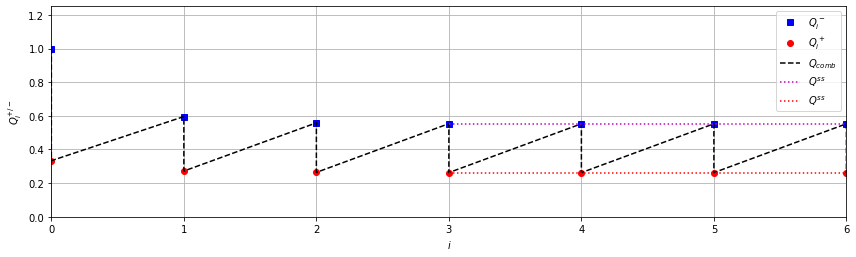

In [ ]:
from scipy import linalg as la

dt = 0.25
d2r2 = (np.pi/180)**2
Rk = 0.5*d2r2
Ck = 1
Q0 = 1*d2r2
alpha = 1

A = np.array((-alpha))
Bw = np.array((alpha))
Wc = 2*d2r2
Nx = 1
S = np.zeros([2*Nx,2*Nx])
S[0:Nx,0:Nx] = -A
S[0:Nx,Nx:2*Nx] = Bw*Bw*Wc

S[Nx:2*Nx,Nx:2*Nx] = A
CC = expm(S*dt)
Ad = np.transpose(CC[Nx:2*Nx,Nx:2*Nx])
Wk = Ad@CC[0:Nx,Nx:2*Nx]

N=6
Qm = np.zeros((1,N+2))
Qp = np.zeros((1,N+2))
Qm[0] = Q0
I = np.arange(0,N+2,1)
for i in I[0:-1]:
  Qp[:,i] = Qm[:,i] - Qm[:,i]**2*Ck**2/(Ck**2*Qm[:,i] + Rk)
  Qm[:,i+1] = Ad**2*Qp[:,i]+ Wk

Qp[:,i+1] = Qm[:,i+1] - Qm[:,i+1]**2*Ck**2/(Ck**2*Qm[:,i+1] + Rk)

Qcomb = np.zeros((1,2*N+4))
II = np.zeros((1,2*N+4))
Qcomb[0,0::2]=Qm
Qcomb[0,1::2]=Qp
II[0,0::2]=I
II[0,1::2]=I

# Solve for discrete steady state Qd (8-18)
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_discrete_are.html
Qdss = la.solve_discrete_are(Ad, Ck, Wk, Rk) # check transposes when using
Qpss = Qdss*Rk/(Qdss+Rk)

fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot2grid((1,1), (0,0), rowspan=1, colspan = 1)

ax1.plot(np.arange(0,Qm.size),Qm[0,:]/d2r2,'bs',label=r'$Q_i^-$')
ax1.plot(np.arange(0,Qp.size),Qp[0,:]/d2r2,'ro',label=r'$Q_i^+$')
ax1.plot(II[0,:],Qcomb[0,:]/d2r2,'k--',label=r'$Q_{comb}}$')
ax1.plot([N/2,N],[Qdss[0,0]/d2r2,Qdss[0,0]/d2r2],'m:',label=r'$Q^{ss}$')
ax1.plot([N/2,N],[Qpss[0,0]/d2r2,Qpss[0,0]/d2r2],'r:',label=r'$Q^{ss}$')
ax1.set_ylim([0,1.25])
ax1.set_xlim([0,N])
ax1.set_xlabel(r'$i$')
ax1.set_ylabel(r'$Q_i^{+/-}$')
ax1.legend()
ax1.grid()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

3) The desired expression for $Q(t)$ is
$$
Q(t) = \frac{aQ_0 + (\alpha^2 W_c -\alpha Q_0)\tanh(at)}{a + \left(\alpha + \frac{Q_0}{R_c}\right)\tanh(at)}
$$
with 
$$
a^2 = \alpha^2 + \alpha^2\frac{W_c}{R_c}
$$
This can be found by solving the Riccati Equation
$$
\dot{Q}(t) = A Q(t) + Q(t)A^T + B_w W_c B_w^T -Q(t)C_y^T R_c^{-1}C_y Q(t)
$$
Since this equation is usually difficult to solve analytically, we employ the method shown in the handout, separating the error covariance into two linear equations
\begin{align}
\dot{X} &= AX + B_wW_cB_w^TZ, \quad X(0) = Q_0 \\
\dot{Z} &= C_y^T R^{-1} C_y X - A^T Z, \quad Z(0) = I,
\end{align}
where
\begin{align}
QZ = X.
\end{align}
For this problem these equations become,
\begin{eqnarray}
\dot{x} &=& -\alpha x + \alpha^2 W_c z \\ 
\dot{z} &=& \frac{1}{R_c}x + \alpha z
\end{eqnarray}
Taking Laplace transforms gives,
\begin{eqnarray}
sX(s) - Q_0 &=& -\alpha X(s) + \alpha^2 W_c Z(s) \\ 
sZ(s) - 1 &=& \frac{1}{R_c}X(s) + \alpha Z(s)
\end{eqnarray}
which become 
\begin{eqnarray}
X(s) &=& \frac{1}{(s + \alpha)} \left[Q_0 + \alpha^2 W_c Z(s)\right] \\
Z(s) &=& \frac{1}{(s - \alpha)} \left[1 + \frac{1}{R_c} X(s)\right]
\end{eqnarray}
Coupling the equations and solving for $X(s)$ and $Z(s)$ gives
\begin{eqnarray}
X(s) &=& \frac{Q_0s + \alpha^2 W_c - \alpha Q_0}{s^2 - \left(\alpha^2 + \alpha^2\frac{W_c}{R_c} \right)}  \\
Z(s) &=& \frac{s + \alpha + \frac{Q_0}{R_c}}{s^2 - \left(\alpha^2 + \alpha^2\frac{W_c}{R_c} \right)} 
\end{eqnarray}
Substituting the expression $a^2 = \alpha^2 + \alpha^2\frac{W_c}{R_c}$ gives
\begin{eqnarray}
X(s) &=& \frac{Q_0s}{s^2 - a^2} + \frac{\alpha^2 W_c - \alpha Q_0}{s^2 - a^2}  \\
Z(s) &=& \frac{s}{s^2 - a^2} +\frac{\alpha + \frac{Q_0}{R_c}}{s^2 - a^2} 
\end{eqnarray}
Using the following Laplace transforms
\begin{eqnarray}
\sinh(at) &=& \frac{a}{s^2 - a^2} \\
\cosh(at) &=& \frac{s}{s^2 - a^2}
\end{eqnarray}
the expressions for $x(t)$ and $z(t)$ become,
\begin{eqnarray}
x(t) &=& Q_0 \cosh(at) + (\alpha^2 W_c - \alpha Q_0) \frac{1}{a} \sinh(at) \\
z(t) &=& \cosh(at) + \left(\alpha + \frac{Q_0}{R_c}\right) \frac{1}{a} \sinh(at)
\end{eqnarray}
and recalling that $Q = XZ^{-1}$, we have that
\begin{eqnarray}
Q(t) &=& \frac{Q_0\cosh(at) + (\alpha^2W_c-\alpha Q_0)\frac{1}{a} \sinh(at)}{\cosh(at) + \left(\alpha + \frac{Q_0}{R_c}\right) \frac{1}{a} \sinh(at)} \\
&=& \frac{aQ_0 + (\alpha^2W_c-\alpha Q_0)\tanh(at)}{a + \left(\alpha + \frac{Q_0}{R_c}\right)\tanh(at)}
\end{eqnarray}

<br>

| <font color='red'>Grading Issue</font> | <font color='red'>Point Deduction</font> |
|----------------------------------------|------------------------------------------|
| did not solve Riccati equation         | -3                                       |

<br>


4) The plot of the discrete and continuous covariance expressions is shown below. Note that the continuous variance falls almost exactly between the time and measurement updates.  In some sense, the continuous variance is the average of these updates.

<br>

| <font color='red'>Grading Issue</font> | <font color='red'>Point Deduction</font> |
|----------------------------------------|------------------------------------------|
| missing plot or discussion         | -2                                       |

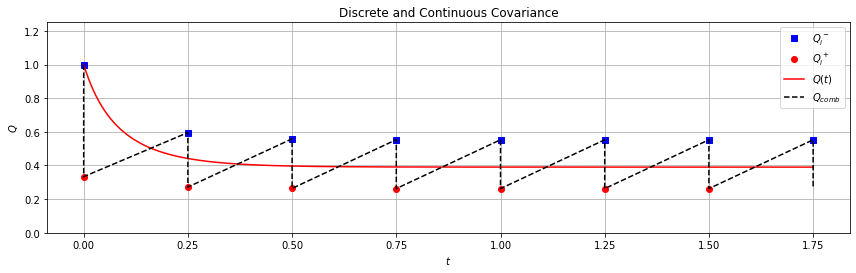

In [ ]:
Rc = Rk*dt

t = np.linspace(0,(N+1)*dt,1000)
a = np.sqrt(alpha**2 + Wc/Rc)
Qt = (Q0*a+(alpha**2 * Wc - alpha*Q0)*np.tanh(a*t))/(a+(alpha+Q0/Rc)*np.tanh(a*t))

fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot2grid((1,1), (0,0), rowspan=1, colspan = 1)

ax1.plot(dt*np.arange(0,Qm.size),Qm[0,:]/d2r2,'bs',label=r'$Q_i^-$')
ax1.plot(dt*np.arange(0,Qp.size-1),Qp[0,:-1]/d2r2,'ro',label=r'$Q_i^+$')
ax1.plot(t,Qt/d2r2,'r-',label=r'$Q(t)$')
ax1.plot(dt*II[0,:],Qcomb[0,:]/d2r2,'k--',label=r'$Q_{comb}$')
ax1.set_ylim([0,1.25])
#ax1.set_xlim([-20,20])
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$Q$')
ax1.legend()
ax1.grid()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.title('Discrete and Continuous Covariance')
plt.show()

# Solutions for the Lab  <font color='red' size=3>[10 points total]</font>

1.- The equations are given by

$$
\underbrace{\dot{\left[\begin{array}{c}
\phi\\
b_{p}\\
\theta\\
b_{q}
\end{array}\right]}}_{\dot{\mathbf{x}}}=\underbrace{\left[\begin{array}{cccc}
0 & -1 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & -1\\
0 & 0 & 0 & 0
\end{array}\right]}_{A}\underbrace{\left[\begin{array}{c}
\phi\\
b_{p}\\
\theta\\
b_{q}
\end{array}\right]}_{\mathbf{x}}+\underbrace{\left[\begin{array}{cc}
1 & 0\\
0 & 0\\
0 & 1\\
0 & 0
\end{array}\right]}_{B}\underbrace{\left[\begin{array}{c}
y_{p}\\
y_{q}
\end{array}\right]}_{\mathbf{u}}+\mathbf{v}
$$

$$
\underbrace{\left[\begin{array}{c}
y_{\phi}\\
y_{\theta}
\end{array}\right]}_{\mathbf{y}}=\underbrace{\left[\begin{array}{cccc}
1 & 0 & 0 & 0\\
0 & 0 & 1 & 0
\end{array}\right]}_{C}\underbrace{\left[\begin{array}{c}
\phi\\
b_{p}\\
\theta\\
b_{q}
\end{array}\right]}_{\mathbf{x}}+\mathbf{w}
$$

2.- The matrices $A_{d}$, $B_{d}$, and $C_{d}$ are as follows:

$$
A_{d}=e^{Adt}=I+Adt+\frac{\left(Adt\right)^{2}}{2}+...=\left[\begin{array}{cccc}
1 & -dt & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & -dt\\
0 & 0 & 0 & 1
\end{array}\right]
$$

$$
B_{d}=\int_{0}^{dt}e^{A\tau}Bd\tau=\left[\begin{array}{cc}
dt & 0\\
0 & 0\\
0 & dt\\
0 & 0
\end{array}\right]
$$

$$
C_{d}=C
$$

3.- Letting $Q_{d}$ denote the intensity of the process noise of the discrete system, and defining $G_d$ as any matrix such that $G_d G_d^T=Q_d$, and making the typical assumption of $E[w_k v_j^T]=0$, we have that the DARE will have at least one positive definite solution if and only if these two conditions hold [1]:

* $(A_d,C_d)$ is detectable

* $(A_d,G_d)$ is controllable on and inside the unit circle

Note that the first condition is satisfied, since [2]
$$\text{rank}\left(\left[\begin{array}{c}
C_d\\
C_dA_d\\
C_dA_d^2\\
C_dA_d^3\\
\end{array}\right]\right)=4$$

The second condition depends on $G_d$, which depends on the value chosen for $Q_{d}$ (a tuning knob in this problem). If the $Q_{d}$ chosen is such that $(A_d,G_d)$ is controllable on and inside the unit circle, then exactly one of the positive definite DARE solutions results in a stable steady-state Kalman filter. 

Note that regardless of the second condition, as the first condition is satisfied we know for sure that the DARE will have at least one positive **semi**definite solution. And at least one such solution results in a marginally stable steady-state Kalman filter [3]. 


[1] Theorem 25 of *"Optimal State Estimation"*, Dan Simon

[2] Theorem 18 (for discrete systems) of *"Optimal State Estimation"*, Dan Simon

[3] Theorem 26 of *"Optimal State Estimation"*, Dan Simon




| <font color='red'>Grading Issue</font> | <font color='red'>Point Deduction</font> |
|----------------------------------------|------------------------------------------|
| missing/incorrect $A$, $B$, and/or $C$         | -1 **per matrix**                                    |
| missing/incorrect $A_d$, $B_d$, and/or $C_d$         | -1 **per matrix**                                    |
| no discussion about observability or controllability | -1  |